<a href="https://colab.research.google.com/github/geun-hyoung/Forecasting_the_number_of_complaints_received/blob/main/Data_Clenaing%26EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Data Load(Concat)& Library 

In [2]:
# google drive
from google.colab import drive
drive.mount('/content/drive') # Connect to drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# 112 factor = 112 신고 접수량의 융합 요소 데이터
factor_19 = pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_19.csv', encoding = 'cp949')
factor_20 = pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_20.csv', encoding = 'cp949')
factor_21 = pd.read_csv('/content/drive/MyDrive/데이터마이닝/112factor_21.csv', encoding = 'cp949')
factor_df = pd.concat([factor_19, factor_20, factor_21], axis = 0)
factor_df.head()

,ACPT_YM,PLCST_NM,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,...,CFINC_ETC,OCRN_DOTW_SNDD,OCRN_DOTW_MON,OCRN_DOTW_TUE,OCRN_DOTW_WED,OCRN_DOTW_THU,OCRN_DOTW_FRI,OCRN_DOTW_SAT,MNTH_AVE_INCOME_AMT,TOTL_RESID_PUL_CNT
0,201901,원주,5014,2916,1500,598,0,14,1090,2899,...,4491,611,617,778,802,813,702,691,NaN,NaN
1,201901,음성,1650,904,463,283,0,10,438,823,...,1509,183,213,250,274,254,227,249,NaN,NaN
2,201901,의령,278,156,73,49,0,1,44,146,...,265,28,29,53,47,42,40,39,NaN,NaN
3,201901,의성,547,287,145,115,0,2,152,247,...,509,67,65,71,88,108,67,81,NaN,NaN
4,201901,의왕,1735,928,501,305,1,23,453,823,...,1637,205,229,262,288,322,218,211,NaN,NaN


In [5]:
# korean_112 = 112신고접수량 데이터
reported_19 = pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_19.csv', encoding = 'cp949')
reported_20 = pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_20.csv', encoding = 'cp949')
reported_21 = pd.read_csv('/content/drive/MyDrive/데이터마이닝/Korea_112_21.csv', encoding = 'cp949')
reported_df = pd.concat([reported_19, reported_20, reported_21], axis = 0)
reported_df.head()

,ACPT_YM,PLCST_NM,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,...,OCRN_TIZN_14,OCRN_TIZN_15,OCRN_TIZN_16,OCRN_TIZN_17,OCRN_TIZN_18,OCRN_TIZN_19,OCRN_TIZN_20,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23
0,201901,ETC,489051,164430,90192,73257,161172,6,248,977,...,26404,26634,26553,26228,25676,24891,25551,26575,24972,22933
1,201901,서울노원,6826,3836,2088,899,3,93,1697,3681,...,271,327,297,335,357,336,303,345,383,437
2,201901,서울방배,2202,1276,696,230,0,18,521,1193,...,95,81,73,124,98,105,114,117,138,188
3,201901,서울중랑,7413,3728,2713,970,2,62,1587,3805,...,315,342,328,305,354,394,432,485,427,497
4,201901,화성동탄,5324,3159,1398,765,2,27,1539,2694,...,232,243,231,252,261,277,262,235,291,325


In [6]:
# 인천 경찰관서
incheon_factor = factor_df[factor_df['PLCST_NM'].str.contains('인천')] 
incheon_df = reported_df[reported_df['PLCST_NM'].str.contains('인천')] 

In [7]:
def change_dt(values):
    return str(values)[0:4] + '-' + str(values)[4:] 

incheon_df['ACPT_YM'] = incheon_df['ACPT_YM'].apply(change_dt)
incheon_factor['ACPT_YM'] = incheon_factor['ACPT_YM'].apply(change_dt)

<ipython-input-7-7f319e672a1b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incheon_df['ACPT_YM'] = incheon_df['ACPT_YM'].apply(change_dt)
<ipython-input-7-7f319e672a1b>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incheon_factor['ACPT_YM'] = incheon_factor['ACPT_YM'].apply(change_dt)


In [8]:
# TIme
import datetime as dt
incheon_df['ACPT_YM'] = incheon_df['ACPT_YM'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m"))
incheon_factor['ACPT_YM'] = incheon_factor['ACPT_YM'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m"))

<ipython-input-8-d2cc82651276>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incheon_df['ACPT_YM'] = incheon_df['ACPT_YM'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m"))
<ipython-input-8-d2cc82651276>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incheon_factor['ACPT_YM'] = incheon_factor['ACPT_YM'].apply(lambda x: dt.datetime.strptime(x, "%Y-%m"))


In [9]:
incheon_factor.dtypes

ACPT_YM                    datetime64[ns]
PLCST_NM                           object
RPRT_CASCNT_WHOL                    int64
RPRT_SEX_MALE                       int64
RPRT_SEX_FMLE                       int64
RPRT_SEX_UNKWN                      int64
RPRT_SEX_ETC                        int64
ACPT_EMERG_TYPE_EMERG               int64
ACPT_EMERG_TYPE_IMPRTNC             int64
ACPT_EMERG_TYPE_GNRL                int64
ACPT_EMERG_TYPE_CVAPP               int64
ACPT_EMERG_TYPE_ETC                 int64
CFINC_DSTVC                         int64
CFINC_DTVC                          int64
CFINC_MRDR                          int64
CFINC_SVLNC                         int64
CFINC_SUCD                          int64
CFINC_INCVLC                        int64
CFINC_ETC                           int64
OCRN_DOTW_SNDD                      int64
OCRN_DOTW_MON                       int64
OCRN_DOTW_TUE                       int64
OCRN_DOTW_WED                       int64
OCRN_DOTW_THU                     

In [10]:
# 마지막 2개 열값이 0 아니면 NaN 값
incheon_factor.isnull().sum()

ACPT_YM                      0
PLCST_NM                     0
RPRT_CASCNT_WHOL             0
RPRT_SEX_MALE                0
RPRT_SEX_FMLE                0
RPRT_SEX_UNKWN               0
RPRT_SEX_ETC                 0
ACPT_EMERG_TYPE_EMERG        0
ACPT_EMERG_TYPE_IMPRTNC      0
ACPT_EMERG_TYPE_GNRL         0
ACPT_EMERG_TYPE_CVAPP        0
ACPT_EMERG_TYPE_ETC          0
CFINC_DSTVC                  0
CFINC_DTVC                   0
CFINC_MRDR                   0
CFINC_SVLNC                  0
CFINC_SUCD                   0
CFINC_INCVLC                 0
CFINC_ETC                    0
OCRN_DOTW_SNDD               0
OCRN_DOTW_MON                0
OCRN_DOTW_TUE                0
OCRN_DOTW_WED                0
OCRN_DOTW_THU                0
OCRN_DOTW_FRI                0
OCRN_DOTW_SAT                0
MNTH_AVE_INCOME_AMT        144
TOTL_RESID_PUL_CNT         144
dtype: int64

In [11]:
element_df = incheon_factor.drop(labels = ['MNTH_AVE_INCOME_AMT', 'TOTL_RESID_PUL_CNT'], axis = 1)
element_df.isnull().sum()

ACPT_YM                    0
PLCST_NM                   0
RPRT_CASCNT_WHOL           0
RPRT_SEX_MALE              0
RPRT_SEX_FMLE              0
RPRT_SEX_UNKWN             0
RPRT_SEX_ETC               0
ACPT_EMERG_TYPE_EMERG      0
ACPT_EMERG_TYPE_IMPRTNC    0
ACPT_EMERG_TYPE_GNRL       0
ACPT_EMERG_TYPE_CVAPP      0
ACPT_EMERG_TYPE_ETC        0
CFINC_DSTVC                0
CFINC_DTVC                 0
CFINC_MRDR                 0
CFINC_SVLNC                0
CFINC_SUCD                 0
CFINC_INCVLC               0
CFINC_ETC                  0
OCRN_DOTW_SNDD             0
OCRN_DOTW_MON              0
OCRN_DOTW_TUE              0
OCRN_DOTW_WED              0
OCRN_DOTW_THU              0
OCRN_DOTW_FRI              0
OCRN_DOTW_SAT              0
dtype: int64

In [12]:
incheon_df.isnull().sum()

ACPT_YM                    0
PLCST_NM                   0
RPRT_CASCNT_WHOL           0
RPRT_SEX_MALE              0
RPRT_SEX_FMLE              0
RPRT_SEX_UNKWN             0
RPRT_SEX_ETC               0
ACPT_EMERG_TYPE_EMERG      0
ACPT_EMERG_TYPE_IMPRTNC    0
ACPT_EMERG_TYPE_GNRL       0
ACPT_EMERG_TYPE_CVAPP      0
ACPT_EMERG_TYPE_ETC        0
OCRN_DOTW_SNDD             0
OCRN_DOTW_MON              0
OCRN_DOTW_TUE              0
OCRN_DOTW_WED              0
OCRN_DOTW_THU              0
OCRN_DOTW_FRI              0
OCRN_DOTW_SAT              0
OCRN_TIZN_00               0
OCRN_TIZN_01               0
OCRN_TIZN_02               0
OCRN_TIZN_03               0
OCRN_TIZN_04               0
OCRN_TIZN_05               0
OCRN_TIZN_06               0
OCRN_TIZN_07               0
OCRN_TIZN_08               0
OCRN_TIZN_09               0
OCRN_TIZN_10               0
OCRN_TIZN_11               0
OCRN_TIZN_12               0
OCRN_TIZN_13               0
OCRN_TIZN_14               0
OCRN_TIZN_15  

In [13]:
x_df = pd.merge(element_df, incheon_df, how = 'inner')

In [14]:
x_df.shape

(408, 50)

In [15]:
x_df.head()

,ACPT_YM,PLCST_NM,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,...,OCRN_TIZN_14,OCRN_TIZN_15,OCRN_TIZN_16,OCRN_TIZN_17,OCRN_TIZN_18,OCRN_TIZN_19,OCRN_TIZN_20,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23
0,2019-01-01,인천강화,1125,467,308,350,0,28,352,450,...,94,69,90,80,55,49,42,47,32,47
1,2019-01-01,인천계양,5032,2808,1606,615,3,125,1654,2432,...,223,201,246,218,243,221,232,248,293,294
2,2019-01-01,인천국제공항경찰단,717,528,172,17,0,5,74,576,...,37,55,34,37,40,40,34,27,23,17
3,2019-01-01,인천남동,6302,3514,2046,740,2,136,1981,3191,...,269,307,260,300,322,271,312,289,391,371
4,2019-01-01,인천논현,3637,1945,1165,527,0,67,1199,1673,...,174,177,210,181,207,189,153,205,182,188


In [16]:
x_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 408 entries, 0 to 407
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   ACPT_YM                  408 non-null    datetime64[ns]
 1   PLCST_NM                 408 non-null    object        
 2   RPRT_CASCNT_WHOL         408 non-null    int64         
 3   RPRT_SEX_MALE            408 non-null    int64         
 4   RPRT_SEX_FMLE            408 non-null    int64         
 5   RPRT_SEX_UNKWN           408 non-null    int64         
 6   RPRT_SEX_ETC             408 non-null    int64         
 7   ACPT_EMERG_TYPE_EMERG    408 non-null    int64         
 8   ACPT_EMERG_TYPE_IMPRTNC  408 non-null    int64         
 9   ACPT_EMERG_TYPE_GNRL     408 non-null    int64         
 10  ACPT_EMERG_TYPE_CVAPP    408 non-null    int64         
 11  ACPT_EMERG_TYPE_ETC      408 non-null    int64         
 12  CFINC_DSTVC              408 non-nul

In [17]:
x_df.describe()

,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,ACPT_EMERG_TYPE_CVAPP,ACPT_EMERG_TYPE_ETC,...,OCRN_TIZN_14,OCRN_TIZN_15,OCRN_TIZN_16,OCRN_TIZN_17,OCRN_TIZN_18,OCRN_TIZN_19,OCRN_TIZN_20,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23
count,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,...,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000,408.000000
mean,5470.105392,2981.281863,1652.838235,834.127451,1.632353,63.514706,1047.132353,3329.127451,399.235294,631.095588,...,264.928922,273.539216,263.735294,267.637255,278.963235,271.308824,283.524510,320.191176,366.073529,332.965686
std,3276.511282,1845.431963,1015.658191,502.338515,2.306306,62.555919,842.908494,2140.329534,289.685619,382.901682,...,154.757724,158.966760,152.961329,157.341834,167.895095,162.333332,172.071508,198.740031,241.954053,212.997131
min,67.000000,48.000000,14.000000,5.000000,0.000000,0.000000,2.000000,21.000000,0.000000,0.000000,...,4.000000,3.000000,3.000000,5.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000
25%,3885.500000,2120.500000,1181.750000,552.500000,0.000000,24.000000,487.750000,2068.250000,174.500000,448.500000,...,194.750000,207.750000,191.750000,199.000000,200.000000,196.250000,193.500000,204.000000,218.750000,198.750000
50%,5572.500000,2983.500000,1673.500000,806.500000,0.000000,37.500000,809.000000,3347.000000,368.000000,629.000000,...,265.500000,274.000000,267.500000,271.500000,283.000000,276.000000,287.000000,323.500000,361.000000,338.000000
75%,6960.750000,3808.000000,2125.500000,1143.250000,3.000000,91.500000,1535.500000,4458.500000,564.250000,821.000000,...,339.000000,347.500000,339.250000,336.250000,353.250000,359.500000,371.000000,433.250000,511.250000,462.500000
max,13114.000000,7560.000000,4076.000000,2127.000000,10.000000,325.000000,4005.000000,9183.000000,1364.000000,2037.000000,...,693.000000,715.000000,641.000000,645.000000,697.000000,650.000000,682.000000,811.000000,1067.000000,873.000000


In [18]:
x_df.describe(include='O')

,PLCST_NM
count,408
unique,12
top,인천강화
freq,35


In [19]:
x_df['Year'] = x_df['ACPT_YM'].dt.year 
x_df['Month'] = x_df['ACPT_YM'].dt.month 

In [20]:
x_df.head()

,ACPT_YM,PLCST_NM,RPRT_CASCNT_WHOL,RPRT_SEX_MALE,RPRT_SEX_FMLE,RPRT_SEX_UNKWN,RPRT_SEX_ETC,ACPT_EMERG_TYPE_EMERG,ACPT_EMERG_TYPE_IMPRTNC,ACPT_EMERG_TYPE_GNRL,...,OCRN_TIZN_16,OCRN_TIZN_17,OCRN_TIZN_18,OCRN_TIZN_19,OCRN_TIZN_20,OCRN_TIZN_21,OCRN_TIZN_22,OCRN_TIZN_23,Year,Month
0,2019-01-01,인천강화,1125,467,308,350,0,28,352,450,...,90,80,55,49,42,47,32,47,2019,1
1,2019-01-01,인천계양,5032,2808,1606,615,3,125,1654,2432,...,246,218,243,221,232,248,293,294,2019,1
2,2019-01-01,인천국제공항경찰단,717,528,172,17,0,5,74,576,...,34,37,40,40,34,27,23,17,2019,1
3,2019-01-01,인천남동,6302,3514,2046,740,2,136,1981,3191,...,260,300,322,271,312,289,391,371,2019,1
4,2019-01-01,인천논현,3637,1945,1165,527,0,67,1199,1673,...,210,181,207,189,153,205,182,188,2019,1


In [21]:
df_19 = x_df[x_df['Year'] == 2019]
df_20 = x_df[x_df['Year'] == 2020]
df_21 = x_df[x_df['Year'] == 2021]

In [65]:
df = [df_19, df_20, df_21]

In [99]:
# 연도, 달, 주
year = x_df.Year.unique()
month = x_df.Month.unique()

week = ['OCRN_DOTW_SNDD', 'OCRN_DOTW_MON', 'OCRN_DOTW_TUE', 'OCRN_DOTW_WED', 
        'OCRN_DOTW_THU', 'OCRN_DOTW_FRI', 'OCRN_DOTW_SAT']
        
hours_1 = ['OCRN_TIZN_0' + str(i) for i in range(0, 10)]
hours_2 = ['OCRN_TIZN_' + str(i) for i in range(10, 24)]
hours = hours_1 + hours_2

time = [i for i in range(24)]

In [25]:
# 각 연도별 총 신고 접수량
y = [df_19['RPRT_CASCNT_WHOL'].sum(),
     df_20['RPRT_CASCNT_WHOL'].sum(), 
     df_21['RPRT_CASCNT_WHOL'].sum()]

In [26]:
# matplotlib 한글 깨짐 현상 해결
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

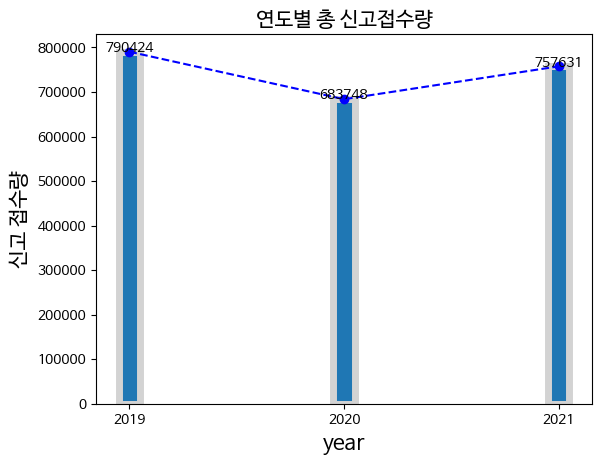

In [34]:
plt.rc('font', family='NanumBarunGothic') 
plt.bar(year, y, align='center', edgecolor='lightgray', width = 0.1,
        linewidth=5, tick_label=year)
import matplotlib.pyplot as plt
for i, v in enumerate(year):
  plt.text(v, y[i], y[i], horizontalalignment = 'center')
plt.rc('font', family='NanumBarunGothic') 
plt.title('연도별 총 신고접수량', fontsize = 15)
plt.xlabel('year', fontsize = 15)
plt.ylabel('신고 접수량', fontsize = 15)
plt.plot(year, y, color='b',
         linestyle='--', marker='o') ## 선 그래프 출력
plt.show()

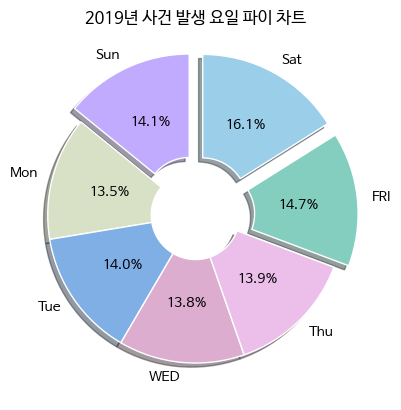

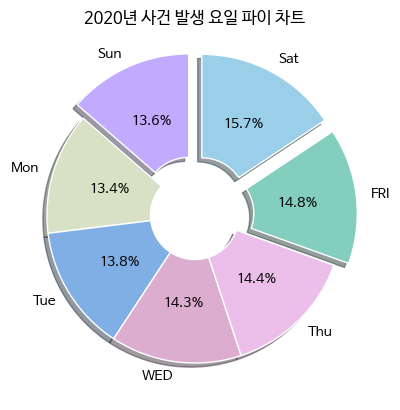

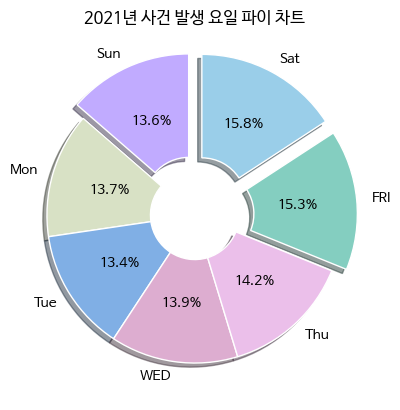

In [108]:
def draw_pieplot(x, year):
  colors = ['#c1abff', '#d8e1c5', '#80afe5', '#ddadd0', '#ebbfea', 
            '#84cec0', '#9acee9', '#d6c2b6', '#d48c9d', '#dcf6c5']

  ratio = [x[i].sum()/x['RPRT_CASCNT_WHOL'].sum() for i in week]
  labels = ['Sun', 'Mon', 'Tue', 'WED', 'Thu', 'FRI', 'Sat']

  explode = [0.1, 0, 0, 0, 0, 0.1,  0.1]
  wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 1}

  plt.title('{0}년 사건 발생 요일 파이 차트'.format(year))
  plt.pie(ratio, labels = labels, autopct = '%.1f%%', startangle=90,
          colors=colors, explode = explode, shadow = True, wedgeprops=wedgeprops)

  plt.show()
  return

for j in range(3):
  draw_pieplot(df[j], year[j])
# plt.savefig('./images/my_pie_chart.png')

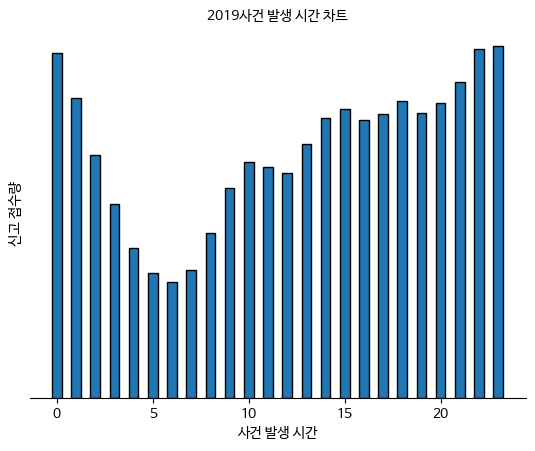

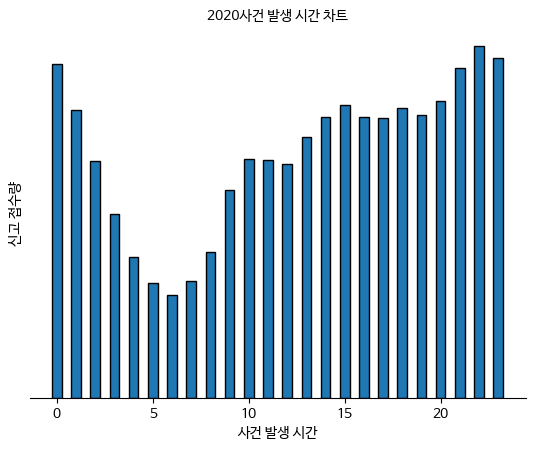

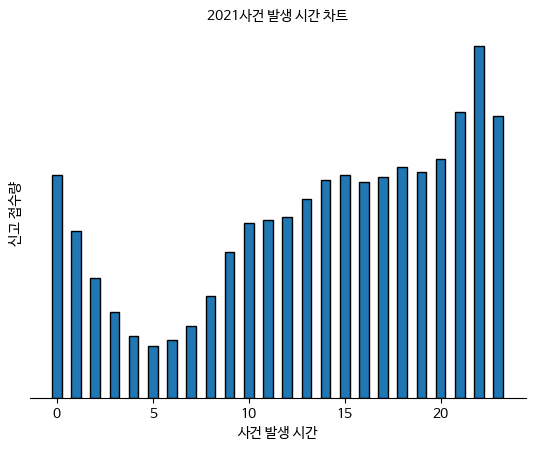

In [107]:
def draw_barplot(year_df, year):
  report_cnt = [year_df[x].sum() for x in hours]  
  plt.bar(time, report_cnt, width = 0.5, edgecolor='black')

  plt.title(f'{year}년 사건 발생 시간 차트', fontsize = 10)
  plt.xlabel('사건 발생 시간', fontsize = 10)
  plt.ylabel('신고 접수량', fontsize = 10)

  plt.yticks(ticks= [])

  plt.gca().spines['right'].set_visible(False) #오른쪽 테두리 제거
  plt.gca().spines['top'].set_visible(False) #위 테두리 제거
  plt.gca().spines['left'].set_visible(False) #왼쪽 테두리 제거

  plt.show()
  print('\n'*3)
  return

for j in range(3):
  draw_barplot(df[j], year[j])

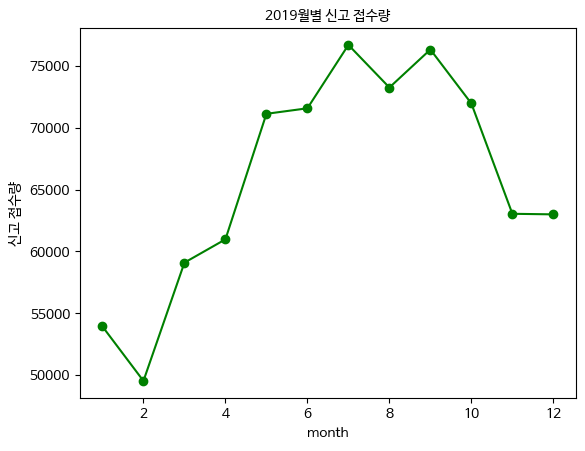

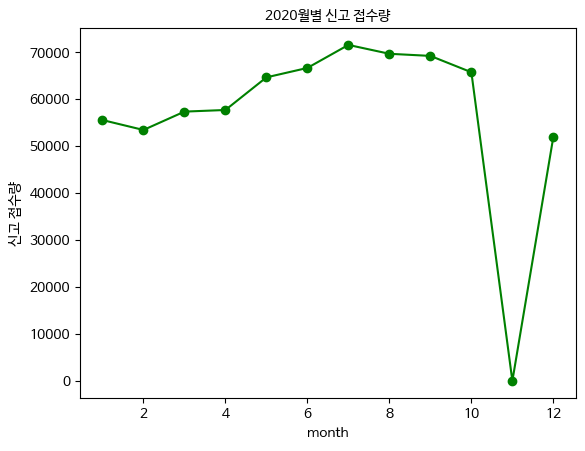

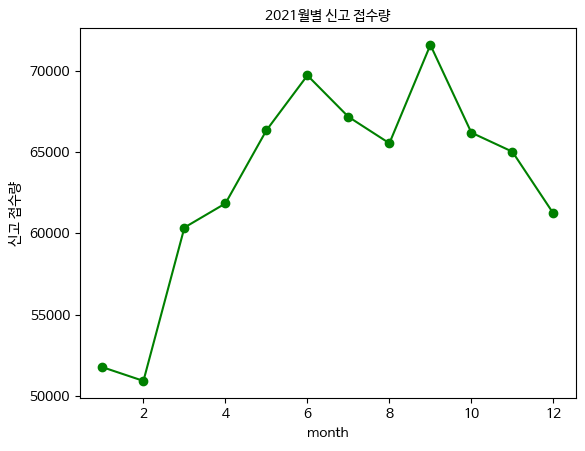

In [122]:
def draw_piplot(year_df, year):
  report_sum = [year_df[year_df['Month'] == x]['RPRT_CASCNT_WHOL'].sum() for x in month]
  plt.plot(month, report_sum, marker='o', color = 'g')
  plt.title(f'{year}년 월별 신고 접수량', fontsize = 10)
  plt.xlabel('month', fontsize = 10)
  plt.ylabel('신고 접수량', fontsize = 10)
  plt.show()

  print('\n'*3)
  return


for j in range(3):
  draw_piplot(df[j], year[j])

In [ ]:
# 전체연도별 사건 접수량
# 요일별 신고 접수량
# 연도별, 시간대별 신고 접수량
#연도별, 경차서별 신고 접수량